In [81]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [82]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.766185,27.847500,27.860001,26.837500,27.332500,212818400,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.506131,15.629000,15.737500,15.348000,15.426000,55664000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.846197,26.378078,26.490770,26.133251,26.168653,28951268,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.819823,26.629999,26.790001,26.393999,26.477501,26480000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.795557,46.660000,47.419998,46.540001,46.759998,27913900,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7539,2019-12-31,AMZN,0.715115,92.099998,92.663002,91.611504,92.391998,50130000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7540,2019-12-31,GOOG,0.656211,66.505501,66.900002,66.454247,66.850998,19236000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7541,2019-12-31,GOOGL,0.777357,66.789497,67.032997,66.606499,66.969498,19514000,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7542,2019-12-31,MSFT,0.683018,156.770004,157.770004,156.449997,157.699997,18369400,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [83]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [84]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1254, 18)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.766185  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.846650  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.712894  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.744531  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.769826  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1248  2019-12-23     0.761074  70.132500  71.062500  70.092499  71.000000   
1249  2019-12-24     0.775495  71.172501  71.222504  70.730003  71.067497   
1250  2019-12-26     0.742264  71.205002  72.495003  71.175003  72.477501   
1251  2019-12-27     0.768797  72.779999  73.492500  72.029999  72.449997   
1252  2019-12-30     0.746877  72.364998  73.172501  71.305000  72.879997   

         Volume  unrate  psr       m2    dspic      pce    

In [85]:
ticker='TSLA'

In [86]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,Volume,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.710122,14.858000,14.883333,14.217333,14.620667,71466000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.728551,14.303333,14.433333,13.810667,14.006000,80527500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.658187,14.004000,14.280000,13.614000,14.085333,93928500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.646626,14.223333,14.318667,13.985333,14.063333,44526000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.696584,14.187333,14.253333,14.000667,14.041333,51637500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [87]:
#putting the close column on the last position
df=df[['Date', 'p_sentiment', 'Open', 'High', 'Low',
       'Volume', 'unrate', 'psr', 'm2', 'dspic', 'pce', 'reer', 'ir', 'ffer',
       'tcs', 'indpro', 'ccpi', 'Close']]

In [88]:
dates = pd.to_datetime(df['Date'])

In [89]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'Volume',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [90]:
df_for_training = df[cols].astype(float)

In [91]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [92]:
print(scaled_data)

[[0.73349331 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.77183473 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.62544497 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.50389745 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.30306162 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]
 [0.28882563 0.89749897 0.94998933 ... 0.57323507 1.         0.95610395]]


In [93]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [94]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [95]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [96]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1251, 7, 17)
(1251, 1)


In [97]:
def build_model(input_shape, output_shape):
    model=Sequential()
    model.add(Bidirectional(LSTM(64,activation='relu',input_shape=input_shape,return_sequences=False)))
    model.add(Dense(output_shape))
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),loss='mse')
    return model

early_stop=EarlyStopping(monitor='val_loss',patience=10)

Epoch 1/100
4/4 [==============================] - 1s 70ms/step - loss: 0.0304 - val_loss: 0.0743
Epoch 2/100
4/4 [==============================] - 0s 30ms/step - loss: 0.0240 - val_loss: 0.0629
Epoch 3/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0185 - val_loss: 0.0527
Epoch 4/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0139 - val_loss: 0.0437
Epoch 5/100
4/4 [==============================] - 0s 39ms/step - loss: 0.0102 - val_loss: 0.0358
Epoch 6/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0074 - val_loss: 0.0291
Epoch 7/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0054 - val_loss: 0.0236
Epoch 8/100
4/4 [==============================] - 0s 27ms/step - loss: 0.0040 - val_loss: 0.0191
Epoch 9/100
4/4 [==============================] - 0s 30ms/step - loss: 0.0032 - val_loss: 0.0155
Epoch 10/100
4/4 [==============================] - 0s 31ms/step - loss: 0.0028 - val_loss: 0.0128
Epoch 11/100
4/4 [=

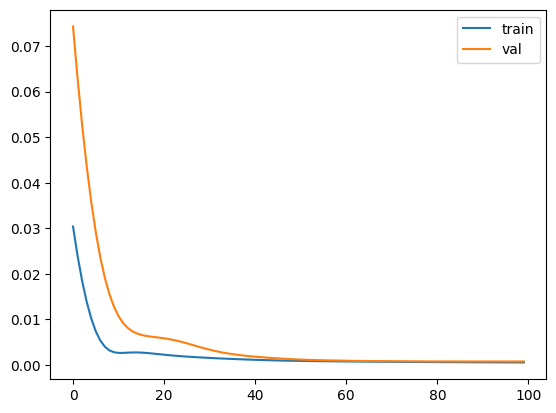

4/4 [==============================] - 0s 3ms/step
mae: 0.893236384801814


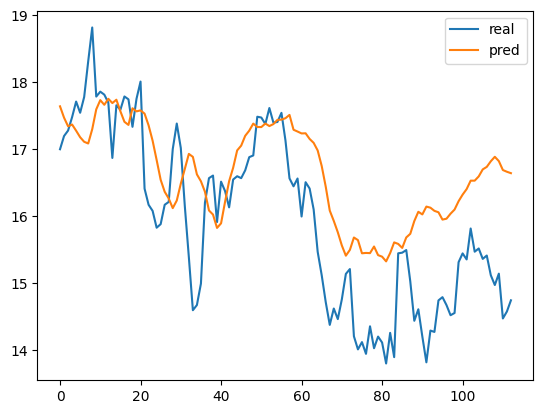

Epoch 1/100
7/7 [==============================] - 2s 50ms/step - loss: 0.0837 - val_loss: 0.0493
Epoch 2/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0626 - val_loss: 0.0330
Epoch 3/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0452 - val_loss: 0.0204
Epoch 4/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0314 - val_loss: 0.0113
Epoch 5/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0209 - val_loss: 0.0054
Epoch 6/100
7/7 [==============================] - 0s 30ms/step - loss: 0.0136 - val_loss: 0.0022
Epoch 7/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0087 - val_loss: 8.6976e-04
Epoch 8/100
7/7 [==============================] - 0s 28ms/step - loss: 0.0059 - val_loss: 8.2988e-04
Epoch 9/100
7/7 [==============================] - 0s 27ms/step - loss: 0.0044 - val_loss: 0.0014
Epoch 10/100
7/7 [==============================] - 0s 26ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 11/10

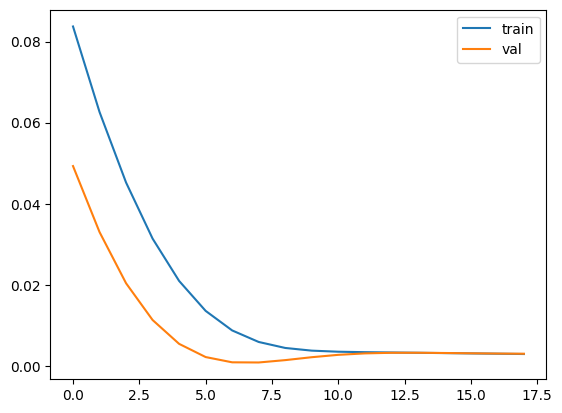

4/4 [==============================] - 0s 4ms/step
mae: 1.5893473808863818


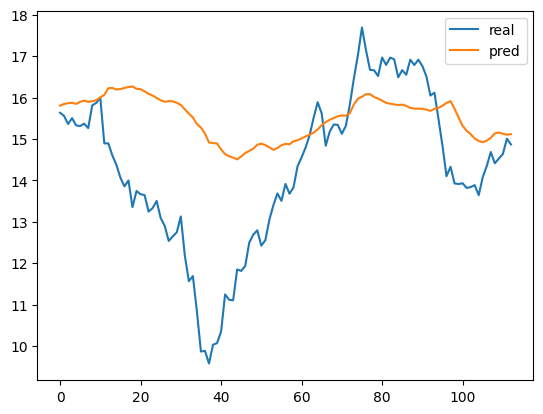

Epoch 1/100
10/10 [==============================] - 1s 40ms/step - loss: 0.0634 - val_loss: 0.0833
Epoch 2/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0429 - val_loss: 0.0612
Epoch 3/100
10/10 [==============================] - 0s 28ms/step - loss: 0.0276 - val_loss: 0.0435
Epoch 4/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0168 - val_loss: 0.0300
Epoch 5/100
10/10 [==============================] - 0s 27ms/step - loss: 0.0100 - val_loss: 0.0203
Epoch 6/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0063 - val_loss: 0.0139
Epoch 7/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0046 - val_loss: 0.0100
Epoch 8/100
10/10 [==============================] - 0s 26ms/step - loss: 0.0040 - val_loss: 0.0078
Epoch 9/100
10/10 [==============================] - 0s 28ms/step - loss: 0.0038 - val_loss: 0.0066
Epoch 10/100
10/10 [==============================] - 0s 27ms/step - loss: 0.0036 - val_loss: 0.0060

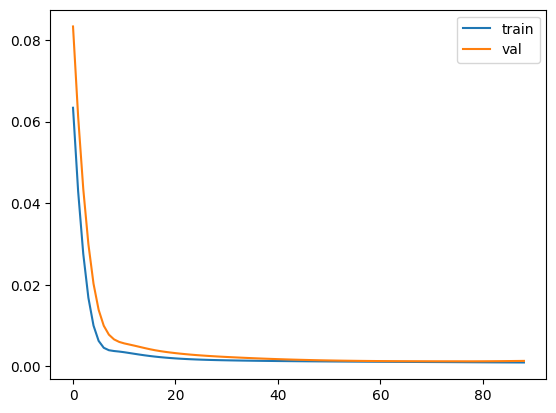

4/4 [==============================] - 0s 4ms/step
mae: 0.6955371875464514


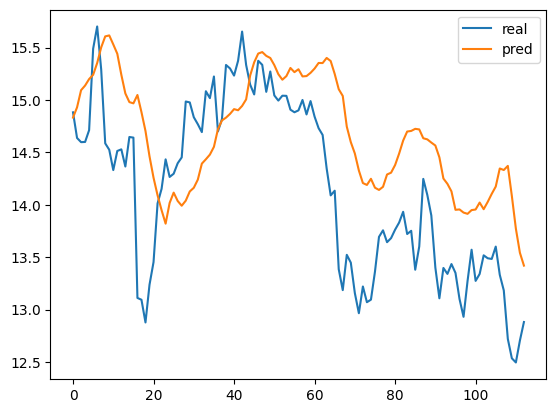

Epoch 1/100
13/13 [==============================] - 1s 36ms/step - loss: 0.0745 - val_loss: 0.0114
Epoch 2/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0471 - val_loss: 0.0032
Epoch 3/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0285 - val_loss: 4.1026e-04
Epoch 4/100
13/13 [==============================] - 0s 28ms/step - loss: 0.0168 - val_loss: 0.0012
Epoch 5/100
13/13 [==============================] - 0s 27ms/step - loss: 0.0103 - val_loss: 0.0038
Epoch 6/100
13/13 [==============================] - 0s 25ms/step - loss: 0.0072 - val_loss: 0.0063
Epoch 7/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0059 - val_loss: 0.0080
Epoch 8/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0054 - val_loss: 0.0086
Epoch 9/100
13/13 [==============================] - 0s 26ms/step - loss: 0.0051 - val_loss: 0.0085
Epoch 10/100
13/13 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 0.

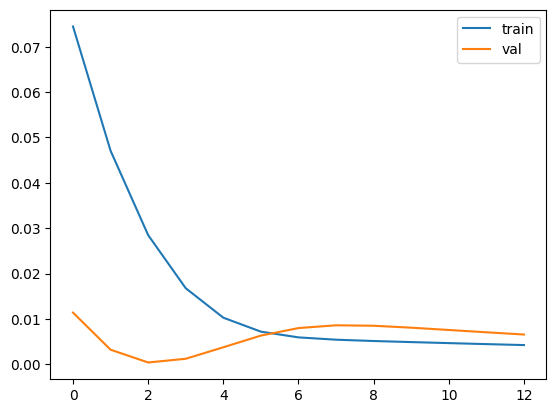

4/4 [==============================] - 0s 5ms/step
mae: 1.6767333992239357


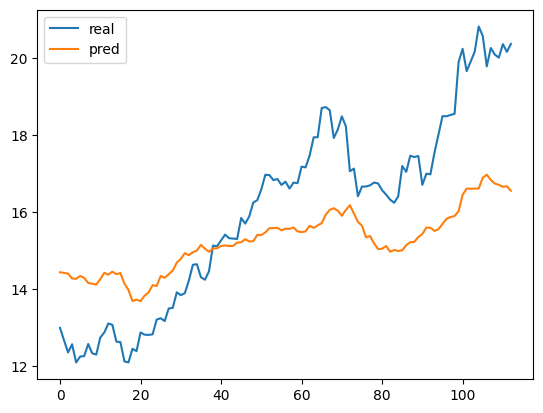

Epoch 1/100
17/17 [==============================] - 2s 34ms/step - loss: 0.0332 - val_loss: 0.0514
Epoch 2/100
17/17 [==============================] - 0s 25ms/step - loss: 0.0114 - val_loss: 0.0149
Epoch 3/100
17/17 [==============================] - 0s 27ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 4/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 5/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0034 - val_loss: 0.0055
Epoch 6/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0030 - val_loss: 0.0059
Epoch 7/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0027 - val_loss: 0.0057
Epoch 8/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0025 - val_loss: 0.0053
Epoch 9/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0022 - val_loss: 0.0049
Epoch 10/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0020 - val_loss: 0.0044

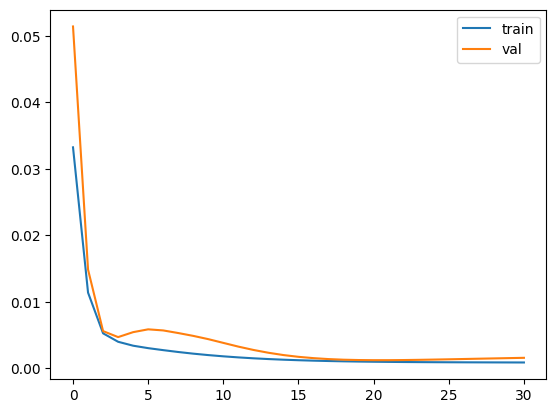

4/4 [==============================] - 0s 4ms/step
mae: 0.7720114824899319


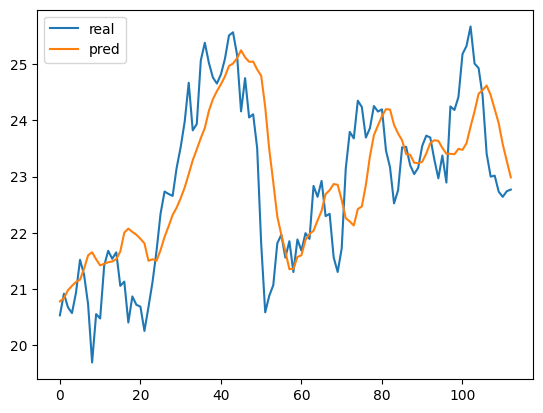

Epoch 1/100
20/20 [==============================] - 2s 31ms/step - loss: 0.0937 - val_loss: 0.2939
Epoch 2/100
20/20 [==============================] - 1s 25ms/step - loss: 0.0402 - val_loss: 0.1598
Epoch 3/100
20/20 [==============================] - 1s 27ms/step - loss: 0.0161 - val_loss: 0.0853
Epoch 4/100
20/20 [==============================] - 0s 25ms/step - loss: 0.0077 - val_loss: 0.0484
Epoch 5/100
20/20 [==============================] - 0s 25ms/step - loss: 0.0058 - val_loss: 0.0317
Epoch 6/100
20/20 [==============================] - 0s 24ms/step - loss: 0.0054 - val_loss: 0.0242
Epoch 7/100
20/20 [==============================] - 0s 24ms/step - loss: 0.0050 - val_loss: 0.0201
Epoch 8/100
20/20 [==============================] - 0s 24ms/step - loss: 0.0046 - val_loss: 0.0171
Epoch 9/100
20/20 [==============================] - 0s 25ms/step - loss: 0.0041 - val_loss: 0.0145
Epoch 10/100
20/20 [==============================] - 0s 24ms/step - loss: 0.0037 - val_loss: 0.0121

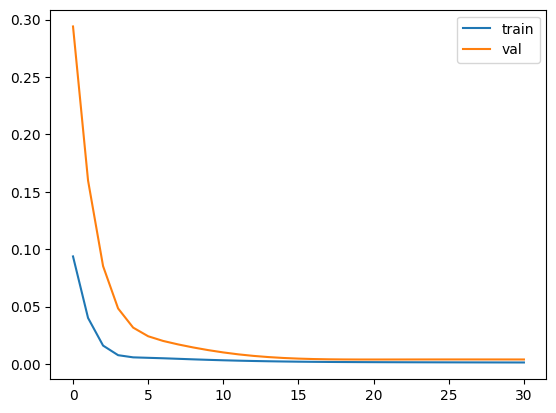

4/4 [==============================] - 0s 4ms/step
mae: 0.916433841941631


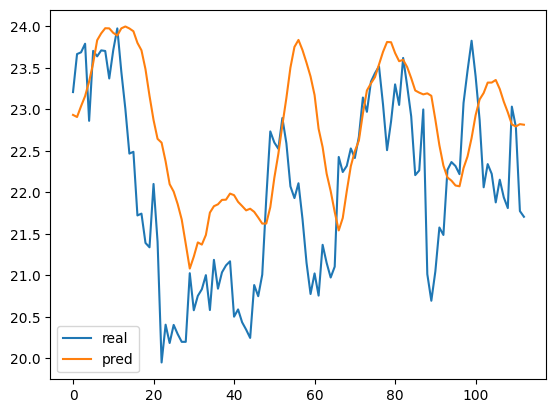

Epoch 1/100
23/23 [==============================] - 2s 30ms/step - loss: 0.1557 - val_loss: 0.3136
Epoch 2/100
23/23 [==============================] - 1s 26ms/step - loss: 0.0719 - val_loss: 0.1541
Epoch 3/100
23/23 [==============================] - 1s 25ms/step - loss: 0.0347 - val_loss: 0.0721
Epoch 4/100
23/23 [==============================] - 1s 25ms/step - loss: 0.0205 - val_loss: 0.0336
Epoch 5/100
23/23 [==============================] - 1s 24ms/step - loss: 0.0157 - val_loss: 0.0169
Epoch 6/100
23/23 [==============================] - 1s 25ms/step - loss: 0.0133 - val_loss: 0.0094
Epoch 7/100
23/23 [==============================] - 1s 24ms/step - loss: 0.0113 - val_loss: 0.0057
Epoch 8/100
23/23 [==============================] - 1s 25ms/step - loss: 0.0094 - val_loss: 0.0036
Epoch 9/100
23/23 [==============================] - 1s 25ms/step - loss: 0.0077 - val_loss: 0.0024
Epoch 10/100
23/23 [==============================] - 1s 25ms/step - loss: 0.0064 - val_loss: 0.0018

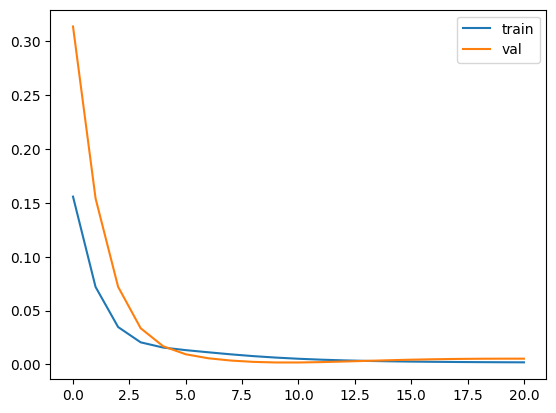

4/4 [==============================] - 0s 4ms/step
mae: 3.0470984421149057


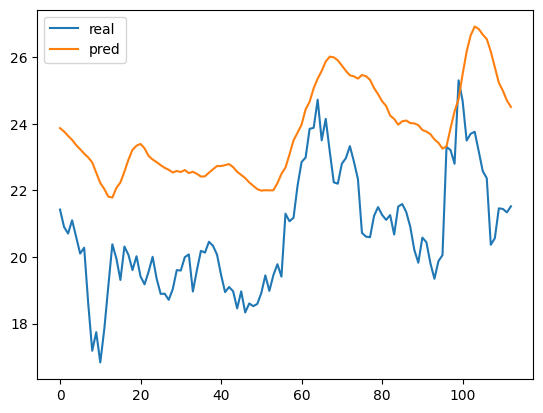

Epoch 1/100
26/26 [==============================] - 2s 29ms/step - loss: 0.0419 - val_loss: 0.0319
Epoch 2/100
26/26 [==============================] - 1s 24ms/step - loss: 0.0078 - val_loss: 0.0041
Epoch 3/100
26/26 [==============================] - 1s 24ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 4/100
26/26 [==============================] - 1s 25ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 5/100
26/26 [==============================] - 1s 24ms/step - loss: 0.0041 - val_loss: 0.0075
Epoch 6/100
26/26 [==============================] - 1s 24ms/step - loss: 0.0033 - val_loss: 0.0083
Epoch 7/100
26/26 [==============================] - 1s 24ms/step - loss: 0.0028 - val_loss: 0.0083
Epoch 8/100
26/26 [==============================] - 1s 24ms/step - loss: 0.0025 - val_loss: 0.0078
Epoch 9/100
26/26 [==============================] - 1s 23ms/step - loss: 0.0023 - val_loss: 0.0070
Epoch 10/100
26/26 [==============================] - 1s 23ms/step - loss: 0.0021 - val_loss: 0.0062

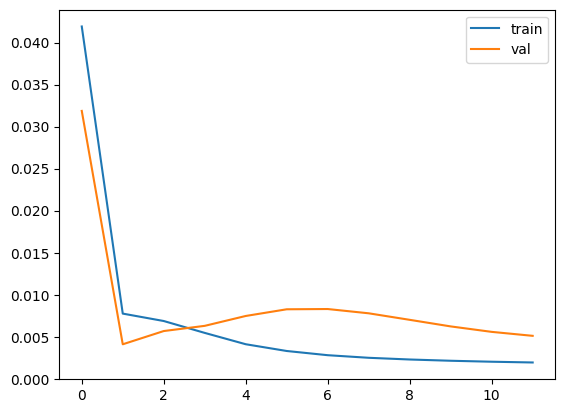

4/4 [==============================] - 0s 4ms/step
mae: 1.1660385375166362


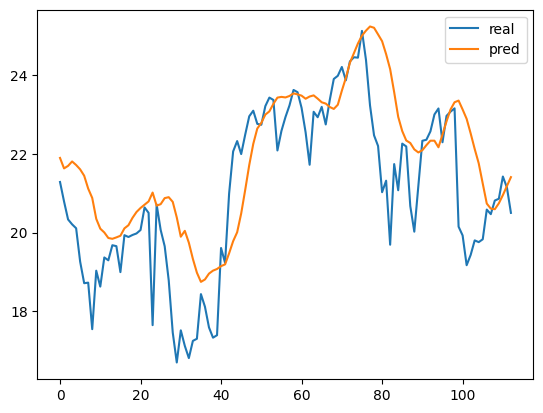

Epoch 1/100
29/29 [==============================] - 2s 29ms/step - loss: 0.2663 - val_loss: 0.2949
Epoch 2/100
29/29 [==============================] - 1s 25ms/step - loss: 0.1229 - val_loss: 0.0970
Epoch 3/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0503 - val_loss: 0.0167
Epoch 4/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0183 - val_loss: 0.0089
Epoch 5/100
29/29 [==============================] - 1s 25ms/step - loss: 0.0093 - val_loss: 0.0229
Epoch 6/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0075 - val_loss: 0.0258
Epoch 7/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0067 - val_loss: 0.0227
Epoch 8/100
29/29 [==============================] - 1s 25ms/step - loss: 0.0062 - val_loss: 0.0195
Epoch 9/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0058 - val_loss: 0.0172
Epoch 10/100
29/29 [==============================] - 1s 24ms/step - loss: 0.0053 - val_loss: 0.0154

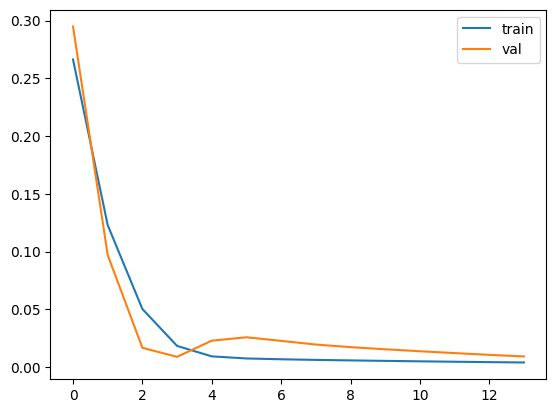

4/4 [==============================] - 0s 5ms/step
mae: 2.660442414014968


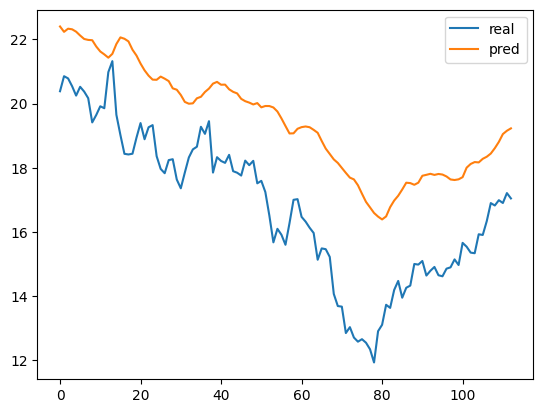

Epoch 1/100
32/32 [==============================] - 1s 14ms/step - loss: 0.1700 - val_loss: 0.0744
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0273 - val_loss: 0.0064
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0088 - val_loss: 0.0215
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0207
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0073 - val_loss: 0.0179
Epoch 6/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0160
Epoch 7/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0058 - val_loss: 0.0139
Epoch 8/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.0116
Epoch 9/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0043 - val_loss: 0.0093
Epoch 10/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0037 - val_loss: 0.0073
Epoch 11

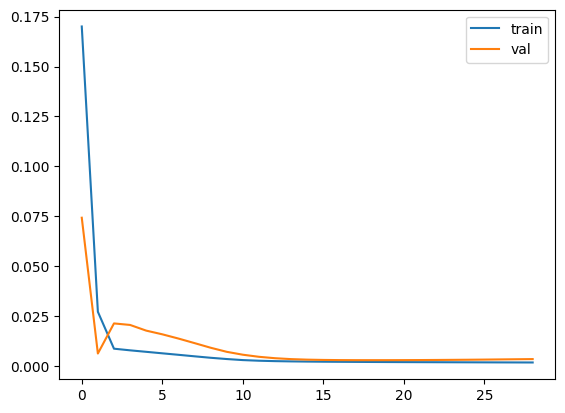

4/4 [==============================] - 0s 3ms/step
mae: 1.2880265776307773


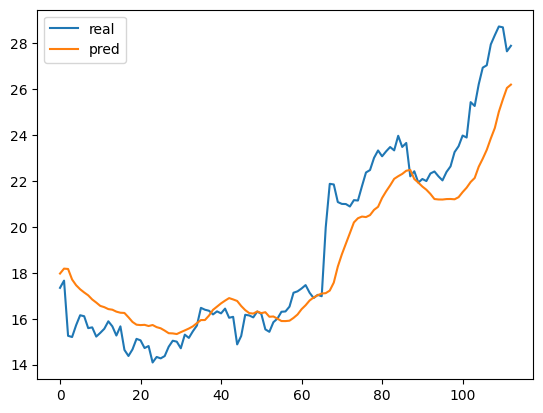

In [98]:
tscv = TimeSeriesSplit(n_splits=10)
maes=[]
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test= y[train_index], y[test_index]
    val_split = int(len(train_index) * 0.9)  # Adjust the validation split percentage as needed
    X_train, x_val = X_train[:val_split], X_train[val_split:]
    y_train, y_val = y_train[:val_split], y_train[val_split:]

    model=build_model(input_shape=(X_train.shape[1],X_train.shape[2]),output_shape=y_train.shape[1])
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(x_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()

    y_test=np.repeat(y_test,X.shape[2],axis=1)
    y_test=scaler.inverse_transform(y_test)[:,-1] 

    y_pred=model.predict(X_test)
    pred=np.repeat(y_pred,X_train.shape[2],axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]
    
    mae=np.mean(np.abs(pred-y_test))
    maes.append(mae)
    print('mae:',mae)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()



In [99]:
model.summary()


Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_49 (Bidirect  (None, 128)               41984     
 ional)                                                          
                                                                 
 dense_49 (Dense)            (None, 1)                 129       
                                                                 
Total params: 42113 (164.50 KB)
Trainable params: 42113 (164.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [100]:
average_mae=np.mean(maes)

print('average mae:',average_mae)

average mae: 1.4704905648167432
